# Clustering with HDBSCAN

In [1]:
#Data manipulation and analysis
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import hdbscan
import umap.umap_ as umap

#Visualization
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)
pd.set_option("display.max_colwidth", 30)

In [2]:
#Loading filtered data
df = pd.read_csv("/Users/dan/PycharmProjects/Arsenal-Striker-Scouting/data/filtered_striker_df.csv")
df.head()

,Unnamed: 0,name,position,nation,age,club,league,mins_played,ninety_mins_played,goals_scored,penalty_goals,non_pen_exp_goals,exp_goals,assists,exp_assists,total_shots,shots_on_target,goals_per_shot,goals_per_sot,shot_on_target_perc,avg_shot_distance,key_passes,shot_creation_per_90,goal_creation_per_90,pass_completion_perc,progressive_carries,total_carries,total_touches,touches_in_attacking_third,touches_in_pen,progressive_runs,times_dispossessed,passes_received,aerial_duels_won,aerial_duels_lost,aerial_duel_win_perc,tackles,tackles_and_interceptions,goals_per_ninety,exp_goals_per_ninety,goals_minus_exp_goals
0,0,Abdallah Sima,"FW,MF",sn SEN,23.0,Brest,fr Ligue 1,1238,13.8,7,0,5.9,5.9,2,1.0,37,18,0.189189,0.388889,48.648649,13.1,13,2.04,0.22,69.6,36,299,510,8,66,92,22,378,41,7,85.416667,15,16,0.507246,0.427536,1.1
1,4,Adam Hložek,"FW,MF",cz CZE,22.0,Hoffenheim,de Bundesliga,1871,20.8,8,0,5.6,5.6,4,3.5,59,24,0.135593,0.333333,40.677966,17.3,20,2.74,0.48,68.5,54,429,761,7,114,102,37,552,40,9,81.632653,22,26,0.384615,0.269231,2.4
2,7,Ademola Lookman,"MF,FW",ng NGA,27.0,Atalanta,it Serie A,2247,25.0,15,1,9.5,10.3,5,7.1,81,32,0.185185,0.468750,39.506173,14.7,61,5.41,0.60,72.5,142,827,1274,8,199,316,51,974,17,8,68.000000,32,35,0.600000,0.412000,4.7
3,14,Alassane Pléa,"MF,FW",fr FRA,32.0,Gladbach,de Bundesliga,1902,21.1,11,1,6.6,7.4,4,3.1,41,12,0.268293,0.916667,29.268293,15.2,25,3.41,0.66,72.1,51,601,979,5,77,141,22,773,15,9,62.500000,7,9,0.521327,0.350711,3.6
4,16,Albert Guðmundsson,"FW,MF",is ISL,27.0,Fiorentina,it Serie A,1273,14.1,6,2,3.1,4.7,1,1.8,25,13,0.240000,0.461538,52.000000,20.6,15,2.76,0.35,83.0,35,402,624,3,32,59,14,466,4,10,28.571429,9,15,0.425532,0.333333,1.3


In [3]:
#dropping rogue column
df = df.drop(columns=['Unnamed: 0'])

In [4]:
#Engineering key features for better comparison
df.loc[:, "progressive_runs_per_ninety"] = df["progressive_runs"] / df["ninety_mins_played"]
df.loc[:, "touches_in_pen_per_ninety"] = df["touches_in_pen"] / df["ninety_mins_played"]
df.loc[:, "aerial_duels_won_per_ninety"] = df["aerial_duels_won"] / df["ninety_mins_played"]
df.loc[:, "shots_on_target_per_ninety"] = df["shots_on_target"] / df["ninety_mins_played"]
df.loc[:, "non_pen_xg_per_ninety"] = df["non_pen_exp_goals"] / df["ninety_mins_played"]
df.loc[:, "xa_per_ninety"] = df["exp_assists"] / df["ninety_mins_played"]

In [5]:
#Checking shape to make sure new features have been added
df.shape

(216, 46)

In [6]:
#Checking for nulls in new features
print(df[["progressive_runs_per_ninety", "touches_in_pen_per_ninety",
          "aerial_duels_won_per_ninety", "shots_on_target_per_ninety",
          "non_pen_xg_per_ninety", "xa_per_ninety", "goals_per_sot",
          "goals_minus_exp_goals", "goals_per_ninety", "age"]]
      .isnull().sum())

progressive_runs_per_ninety    0
touches_in_pen_per_ninety      0
aerial_duels_won_per_ninety    0
shots_on_target_per_ninety     0
non_pen_xg_per_ninety          0
xa_per_ninety                  0
goals_per_sot                  0
goals_minus_exp_goals          0
goals_per_ninety               0
age                            0
dtype: int64


In [7]:
#Selecting features based on EDA with the objective of finding an elite goalscorer
feature_selection = df[[
    "progressive_runs_per_ninety", "touches_in_pen_per_ninety",
    "aerial_duels_won_per_ninety", "shots_on_target_per_ninety",
    "non_pen_xg_per_ninety", "xa_per_ninety", "goals_per_sot",
    "goals_minus_exp_goals", "goals_per_ninety", "age"
]]

In [8]:
#Scaling ready for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_selection)

### HDBSCAN v1

In [9]:
#Starting with a default cluster size
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)
cluster_labels = model.fit_predict(X_scaled)

In [10]:
#Creating a cluster label to inspect the results
df["cluster"] = cluster_labels

In [11]:
#Checking clusters
print(df["cluster"].value_counts())

cluster
-1    200
 0      8
 1      8
Name: count, dtype: int64


The majority of players have been categorized as outliers, suggesting the model has not done a good job of finding elite players.

In [12]:
#Getting cluster stability scores
cluster_stability = model.cluster_persistence_
for i, score in enumerate(cluster_stability):
    print(f"Cluster {i}: Stability = {score:.3f}")

Cluster 0: Stability = 0.031
Cluster 1: Stability = 0.045


Stability scores confirm the model is not yet effective.

In [13]:
#Outlier score: higher = more likely to be an outlier
df["outlier_score"] = model.outlier_scores_

#Show the most outlier-ish players
print(df[["name","outlier_score"]].sort_values(by="outlier_score", ascending=False).head(10))

                   name  outlier_score
11    Alexander Sørloth       0.701634
169     Ousmane Dembélé       0.688305
86        Gonçalo Ramos       0.664363
168       Omar Marmoush       0.653668
122       Kylian Mbappé       0.638571
171       Patrik Schick       0.610510
156       Mohamed Salah       0.601226
187       Rodrigo Muniz       0.592359
184  Robert Lewandowski       0.557172
152        Mika Biereth       0.545876


These are all elite level players confirming that the outliers are who we are looking for. If we can reduce the outlier group size, we might find our target.

### Dimension reduction

In [14]:
#Reducing to 2 dimensions for visualization
umap_reducer = umap.UMAP(n_components=2)
X_umap = umap_reducer.fit_transform(X_scaled)

#Add to dataframe
df["umap_1"] = X_umap[:, 0]
df["umap_2"] = X_umap[:, 1]

In [15]:
model_umap = hdbscan.HDBSCAN(min_cluster_size=5, prediction_data=True)
cluster_labels_umap = model_umap.fit_predict(X_umap)

#Adding cluster labels
df["umap_cluster"] = cluster_labels_umap

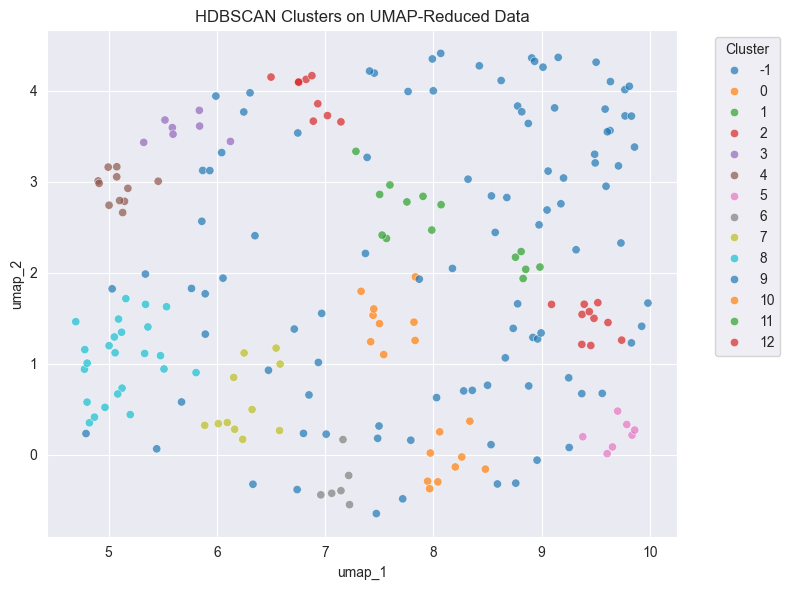

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="umap_1",
    y="umap_2",
    hue="umap_cluster",
    palette="tab10",
    alpha=0.7
)
plt.title("HDBSCAN Clusters on UMAP-Reduced Data")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [19]:
#Checking cluster sizes
df["umap_cluster"].value_counts()

umap_cluster
-1     86
 8     24
 9     13
 7     11
 4     11
 12    10
 2      9
 1      9
 0      9
 10     9
 3      7
 5      7
 6      6
 11     5
Name: count, dtype: int64

In [20]:
#Filter out outliers
mask = df["umap_cluster"] != -1
score = silhouette_score(X_umap[mask], df["umap_cluster"][mask])
print("Silhouette Score (excluding outliers):", score)


Silhouette Score (excluding outliers): 0.6048708


When we remove outliers from the calculation, we are seeing significant improvements in the silhouette score. However, outliers still represent a large volume of players.

I will optimize this model further by applying hyperparameter tuning.

### Hyperparameter tuning

In [21]:
#Hyperparameter grids
neighbors_list = [5, 10, 15, 30, 50, 75, 100]
min_dist_list = [0.0, 0.05, 0.1, 0.25, 0.5, 0.7]
min_cluster_sizes = [5, 7, 10, 15, 20]
min_samples_list = [1, 3, 5, 7, 10]

results = []

In [22]:
#Grid search
for n_neighbors in neighbors_list:
    for min_dist in min_dist_list:
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        embedding = reducer.fit_transform(X_scaled)

        for min_cluster_size in min_cluster_sizes:
            for min_samples in min_samples_list:
                model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                            min_samples=min_samples,
                                            prediction_data=True)
                cluster_labels = model.fit_predict(embedding)

                if len(set(cluster_labels)) > 1 and -1 in cluster_labels:
                    score = silhouette_score(embedding[cluster_labels != -1], cluster_labels[cluster_labels != -1])
                    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
                    results.append({
                        "n_neighbors": n_neighbors,
                        "min_dist": min_dist,
                        "min_cluster_size": min_cluster_size,
                        "min_samples": min_samples,
                        "silhouette_score": score,
                        "num_clusters": num_clusters
                    })


In [23]:
#Top results
results_df = pd.DataFrame(results)
results_df.sort_values(by="silhouette_score", ascending=False, inplace=True)
print(results_df.head(10))

     n_neighbors  min_dist  min_cluster_size  min_samples  silhouette_score  num_clusters
554           30      0.50                20           10          0.659556             2
549           30      0.50                15           10          0.659556             2
2              5      0.00                 5            5          0.624888            16
484           30      0.10                 5           10          0.623449             4
34             5      0.05                 7           10          0.611661             4
38             5      0.05                10           10          0.611661             4
41             5      0.05                15           10          0.611661             4
43             5      0.05                20           10          0.611661             4
29             5      0.05                 5           10          0.611661             4
244           10      0.50                 7           10          0.601908             4


I will select parameters with 16 clusters because 2 feel too few to identify meaningful groupings.

### HDBSCAN v2

In [24]:
#Rerunning model with optimal parameters
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.0, random_state=42)
umap_embedding = umap_model.fit_transform(X_scaled)

# Add UMAP results to dataframe
df["umap_1"] = umap_embedding[:, 0]
df["umap_2"] = umap_embedding[:, 1]


In [25]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)
cluster_labels = model.fit_predict(umap_embedding)

#Adding cluster labels
df["umap_cluster"] = cluster_labels

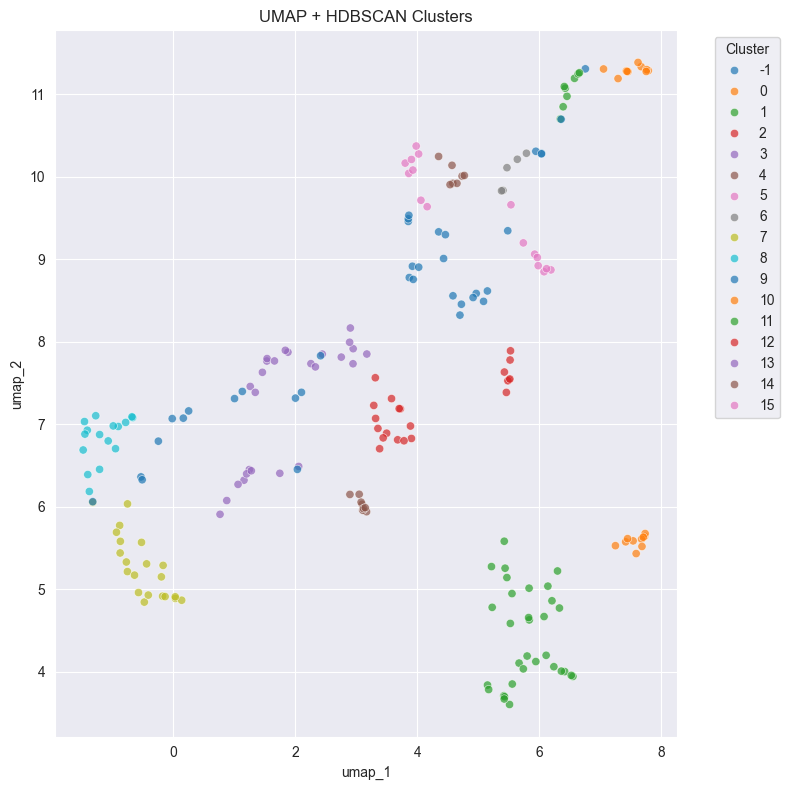

In [56]:
#Plotting clusters
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df, x="umap_1", y="umap_2", hue="umap_cluster", palette="tab10", alpha=0.7)

plt.title("UMAP + HDBSCAN Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [79]:
#Checking clusters
print(df["umap_cluster"].value_counts())

umap_cluster
 1     32
-1     30
 7     21
 13    17
 8     16
 12    14
 10    10
 0     10
 3      9
 15     8
 4      8
 5      8
 11     8
 14     7
 2      7
 9      6
 6      5
Name: count, dtype: int64


The clusters are now much more evenly spread, and the groupings are logical.

Next, I will analyse the clusters to inform the final shortlist.

In [67]:
#Select key metrics
key_metrics = ["goals_per_ninety", "shots_on_target_per_ninety",
               "non_pen_xg_per_ninety", "progressive_runs_per_ninety", "touches_in_pen_per_ninety",
               "aerial_duels_won_per_ninety", "xa_per_ninety", "goals_per_sot",
               "goals_minus_exp_goals"
               ]

#Group and describe
cluster_profiles = df.groupby("umap_cluster")[key_metrics].median().round(2)
print(cluster_profiles)

              goals_per_ninety  shots_on_target_per_ninety  non_pen_xg_per_ninety  progressive_runs_per_ninety  touches_in_pen_per_ninety  \
umap_cluster                                                                                                                                
-1                        0.32                        0.93                   0.26                         7.58                       3.86   
 0                        0.41                        1.25                   0.49                         6.76                       5.86   
 1                        0.75                        1.35                   0.57                         5.88                       6.11   
 2                        0.36                        0.98                   0.31                         5.44                       3.82   
 3                        0.36                        0.56                   0.23                         4.31                       3.43   
 4           

Cluster 1 appears to contain the most elite group of goalscorers with top results across key goal scoring metrics. I will explore this group further.

### Final filters and sorting

In [86]:
#Defining top players to label
top_strikers = df[df["umap_cluster"] == 1].sort_values("goals_per_ninety", ascending=False)
print(top_strikers[["name", "age", "club", "goals_per_ninety"
              ]].head(10))

                   name   age             club  goals_per_ninety
11    Alexander Sørloth  29.0  Atlético Madrid          1.149425
171       Patrik Schick  29.0       Leverkusen          1.122995
169     Ousmane Dembélé  28.0        Paris S-G          1.093750
88           Harry Kane  31.0    Bayern Munich          0.981132
122       Kylian Mbappé  26.0      Real Madrid          0.959752
152        Mika Biereth  22.0           Monaco          0.955882
146       Mateo Retegui  26.0         Atalanta          0.943396
47     Cristhian Stuani  38.0           Girona          0.916667
184  Robert Lewandowski  36.0        Barcelona          0.912162
29          Ayoze Pérez  31.0       Villarreal          0.867580


The model has successfully identified a group of elite strikers. I will organize this group and apply final filters to establish a shortlist.

In [84]:
#Creating shortlist based on goal efficiency and filtering by age
shortlist = top_strikers[top_strikers["age"] < 29].sort_values("goals_minus_exp_goals", ascending=False)

#Keeping the top 10 players
arsenal_targets = shortlist[
    ["name", "club", "goals_scored", "goals_minus_exp_goals", "goals_per_ninety", "shots_on_target_per_ninety", "goals_per_sot",
     "non_pen_xg_per_ninety"]].head(10)
print(arsenal_targets)

                  name           club  goals_scored  goals_minus_exp_goals  goals_per_ninety  shots_on_target_per_ninety  goals_per_sot  non_pen_xg_per_ninety
146      Mateo Retegui       Atalanta            25                    6.1          0.943396                    1.207547       0.781250               0.562264
122      Kylian Mbappé    Real Madrid            31                    5.1          0.959752                    2.321981       0.413333               0.575851
169    Ousmane Dembélé      Paris S-G            21                    4.4          1.093750                    2.552083       0.428571               0.822917
141      Marcus Thuram          Inter            14                    4.1          0.551181                    1.062992       0.518519               0.389764
51           Dani Olmo      Barcelona            10                    3.5          0.740741                    1.111111       0.666667               0.362963
107  Jonathan Burkardt       Mainz 05         

In [26]:
#Saving the model for future use
import pickle
import os

#defining a location to save the model
pickle_dir = "/Users/dan/PycharmProjects/Arsenal-Striker-Scouting/model"
model_filename = "final_model.pkl"

#Constructing the full file path
pickle_path = os.path.join(pickle_dir, model_filename)

#Saving the model
with open(pickle_path, 'wb') as f:
    pickle.dump(model, f)

print(f"model saved as pickle file at: {pickle_path}")

model saved as pickle file at: /Users/dan/PycharmProjects/Arsenal-Striker-Scouting/model/final_model.pkl
